In [82]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set(style="darkgrid")
#import bayespy 

import pymc3 as pm
import arviz as az
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import ks_2samp

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#%load_ext watermark
#%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
path = r'x:\CAO\Team\Client\BET\PerformanceLink\2021_05_Sistas S3\$Analysis\4. Model\Model Input\$ final model\dig.csv'
data = pd.read_csv(path)

In [84]:
data.head()

,DIG_BUSTLE_NOTDEMO,DIG_BUSTLE_INDEMO,DIG_BUZZFEED_NOTDEMO,DIG_BUZZFEED_INDEMO,DIG_VIZIO_NOTDEMO,DIG_VIZIO_INDEMO,TOTAL_CONV
0,0,0.0,0.0,0.0,0,0,6
1,0,0.0,0.0,0.0,0,0,4
2,0,0.0,0.0,0.0,0,0,0
3,0,0.0,0.0,0.0,0,0,6
4,0,0.0,0.0,0.0,0,0,0


In [85]:
# data = data[data.TOTAL_CONV != 0]
data = data[(data.TOTAL_CONV<20)] # & (data.TOTAL_CONV!=0)

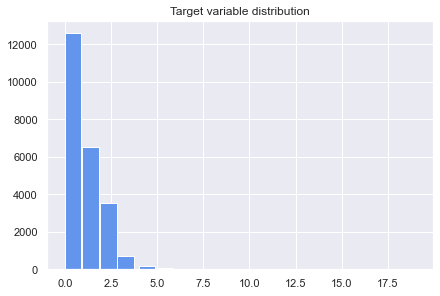

In [119]:
# target variable distribution
plt.hist(data.TOTAL_CONV,
         color = 'cornflowerblue', 
         width=0.9, bins =100)

plt.title(label= 'Target variable distribution')
plt.show()

In [121]:
x = data[[col for col in data.columns if col != 'TOTAL_CONV']].values
y = data.TOTAL_CONV.values

In [122]:
with pm.Model() as model_negative_binomial:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)
        # Slope
        beta = pm.HalfNormal('beta', sd = 10, shape = len(data.columns[:-1]))
        # Error term
        eps = pm.Gamma('eps', alpha = 1, beta = 0.5)
        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        # Likelihood (sampling distribution) of observations
        conv = pm.NegativeBinomial('conv', 
                                   mu = mu, 
                                   alpha= eps,  
                                   observed=y)
        pm.Potential('constrain', tt.switch(conv > y.max(), -np.inf, 0.))
        trace_negative_binomial = pm.sample(chains = 4, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 566 seconds.


posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


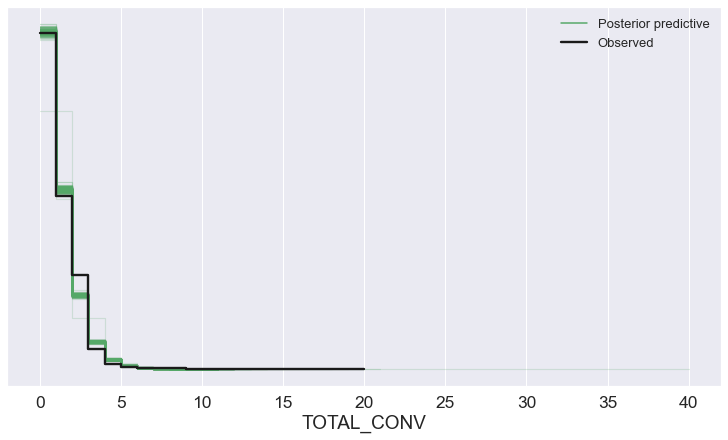

R2 for Model is : 0.005


In [123]:
predictions_negative_binomial = ppc_check(model = model_negative_binomial, 
                                          data = data, 
                                          trace = trace_negative_binomial, 
                                          predictions= True)

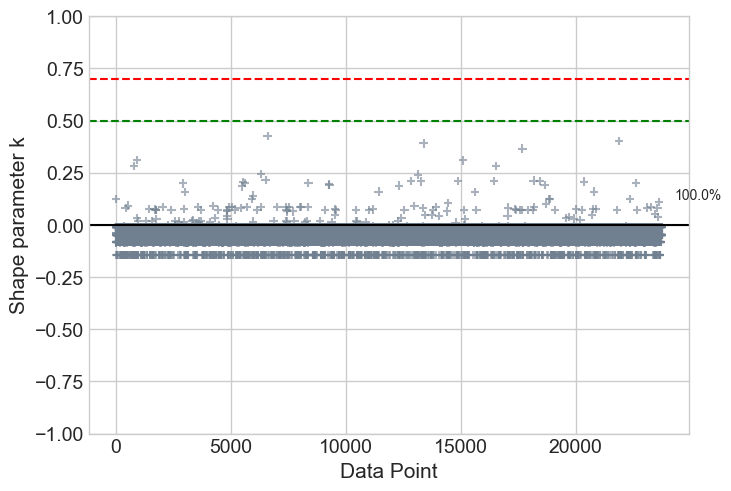

In [124]:
# compute with arviz InferenceData type
p_loo_zinb = pm.loo(trace_negative_binomial, pointwise=True, var_name='conv')

# plot khat diagnostic
plt.style.use("arviz-whitegrid")
pm.plot_khat(p_loo_zinb, show_bins=True, color='slategray', alpha=0.6)
plt.axhline(0.5, color = 'green', linestyle='dashed')
plt.axhline(0.7, color = 'red', linestyle='dashed')
plt.axhline(0, color='black')
plt.ylim((-1, 1))
plt.show()

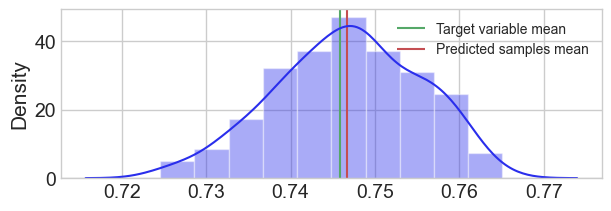

In [126]:
samples_mean = [sample.mean() for sample in predictions_negative_binomial['conv']]

plt.figure(figsize=(6,2))
ax = sns.distplot(samples_mean,)
plt.vlines(y.mean(), *ax.set_ylim(), color='g', label='Target variable mean')
plt.vlines(predictions_negative_binomial['conv'].flatten().mean(), 
           *ax.set_ylim(),
           label='Predicted samples mean',  
           color='r')
plt.legend(loc=1, fontsize ='medium')
plt.show()

In [127]:
# az.summary(trace_negative_binomial, var_names='beta').set_index(data.columns[:-1])

### Modifying params for likelihood function

In [64]:
with pm.Model() as model_negative_binomial_mod:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)
        # Slope
        beta = pm.HalfNormal('beta', sd = 10, shape = len(data.columns[:-1]))
        # Error term
        phi = pm.Gamma('eps', alpha = 1, beta = 0.5)
        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        l = pm.math.exp(mu)
        # Likelihood (sampling distribution) of observations
        conv = pm.NegativeBinomial('conv', 
                                   mu = l, 
                                   alpha= phi,  
                                   observed=y)
        
        pm.Potential('constrain', tt.switch(conv > y.max(), -np.inf, 0.))
        trace_negative_binomial_mod = pm.sample(chains = 4, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 673 seconds.


posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


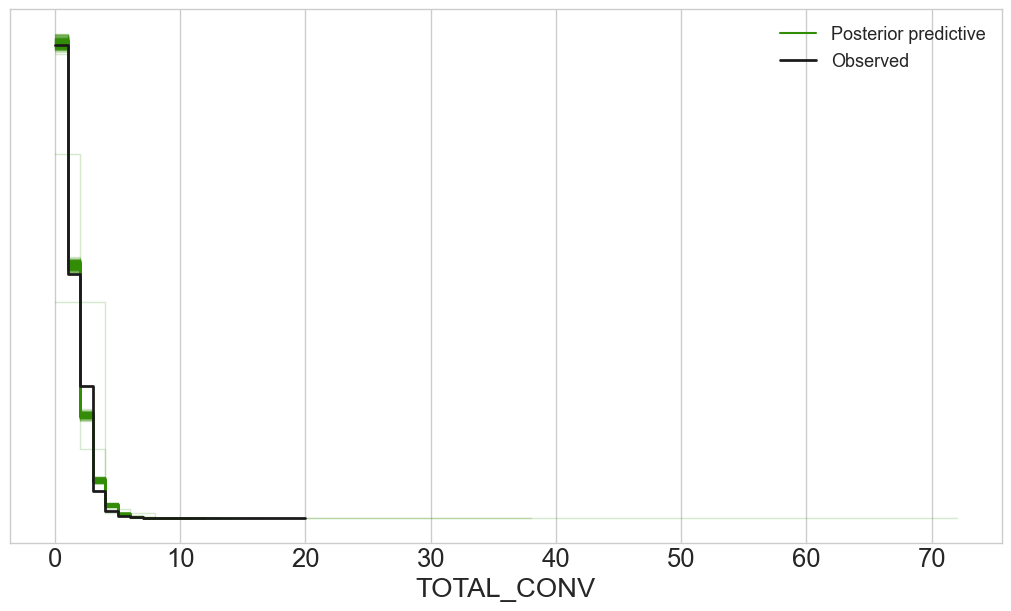

R2 for Model is : 0.005


In [128]:
predictions_negative_binomial_mod=ppc_check(model = model_negative_binomial_mod, 
                                            trace = trace_negative_binomial_mod, 
                                            data = data, 
                                            predictions= True)

In [129]:
# az.summary(trace_negative_binomial_mod, var_names='beta').set_index(data.columns[:-1])

In [188]:
# az.convert_to_inference_data(trace_negative_binomial)

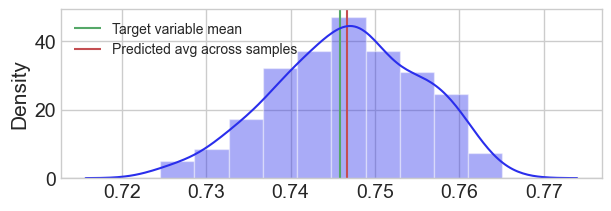

In [187]:
samples_mean = [sample.mean() for sample in predictions_negative_binomial['conv']]

plt.figure(figsize=(6,2))
ax = sns.distplot(samples_mean,)
plt.vlines(y.mean(), *ax.set_ylim(), color='g', label='Target variable mean')
plt.vlines(predictions_negative_binomial['conv'].flatten().mean(), 
           *ax.set_ylim(),
           label='Predicted avg across samples',  
           color='r')
plt.legend(loc=0, fontsize ='medium')
plt.show()

In [131]:
def skew(y):
    '''Compute Fisher-Pearson skew coefficient for values of y'''
    n = len(y)
    dif = y - y.mean()
    skew_stat = (np.sqrt(n-1)/(n-2))*n*(np.sum(dif**3)/(np.sum(dif**2)**1.5))
    return skew_stat

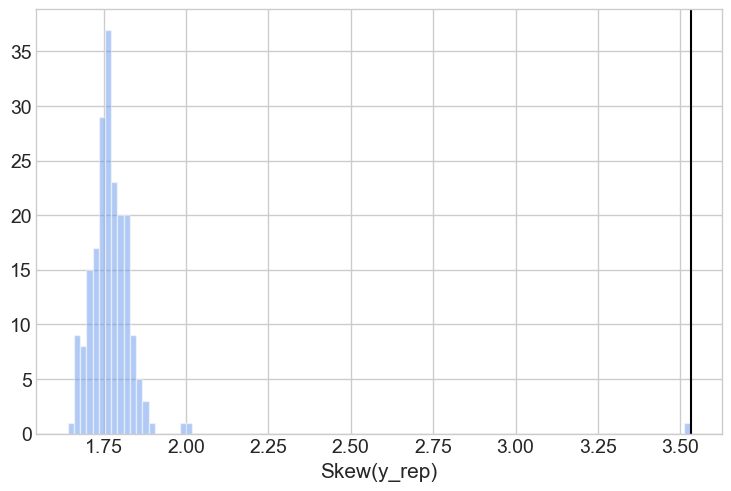

In [183]:
# Plot observed and simulated skewness ----------                                        
plt.hist([skew(y) for y in predictions_negative_binomial['conv']], 
         bins=100, alpha=0.5, color='cornflowerblue'
        )
plt.axvline(skew(data.TOTAL_CONV.values), color='black')
plt.xlabel('Skew(y_rep)')
plt.show()

In [138]:
l_skew_p = [skew(y) for y in predictions_negative_binomial_mod['conv']]

In [137]:
skew(y)

3.5324320342546343

### Mean Squared Prediction Error (MSPE)

In [175]:
def mpse(samples, y):
    """
    Compute mpse for each sample
    return - mean value across all mpse samples
    samples - 2d array
    y - observed 1d array
    """
    n = len(y)
    mpse_list = [] # list of mpse for each sample 
    for sample in samples:
        mpse_list.append(sum([(sample.mean()-obs)**2 for obs in y])/n)
    return sum(mpse_list)/len(mpse_list)

In [177]:
mpse(predictions_negative_binomial_mod['conv'][:20], y)

1.1639785324356269

In [181]:
az.summary(trace_negative_binomial)[["mean", "hdi_3%", "hdi_97%"]]

,mean,hdi_3%,hdi_97%
alpha,0.746,0.734,0.759
beta[0],0.005,0.000,0.015
beta[1],0.005,0.000,0.015
beta[2],0.006,0.000,0.018
beta[3],0.006,0.000,0.017
beta[4],0.200,0.000,0.584
beta[5],0.077,0.000,0.242
eps,1.870,1.738,1.999


In [182]:
az.summary(trace_negative_binomial_mod)[["mean", "hdi_3%", "hdi_97%"]]

,mean,hdi_3%,hdi_97%
alpha,-0.294,-0.310,-0.278
beta[0],0.006,0.000,0.016
beta[1],0.005,0.000,0.014
beta[2],0.007,0.000,0.019
beta[3],0.007,0.000,0.019
beta[4],0.119,0.000,0.312
beta[5],0.030,0.000,0.077
eps,1.872,1.739,1.998


In [190]:
dftrc_lin = pm.trace_to_dataframe(trace_negative_binomial)

In [192]:
pm.stats.dic(model=model_negative_binomial, trace=trace_negative_binomial)

AttributeError: module 'pymc3.stats' has no attribute 'dic'

In [197]:
weekly_reservations = np.array([    14,     41,     41,     44,     74,    104,    162,    205,
           274,    329,    372,    473,    534,    666,    788,    927,
          1147,   1399,   1673,   2007,   2476,   3003,   3674,   4344,
          5237,   6306,   8026,   9895,  12125,  14792,  18071,  21929,
         26690,  32855,  39759,  48684,  59371,  71765,  86179, 102734,
        121958, 142976, 166365, 191495, 218210, 245875, 272319, 298141,
        323690, 349570, 375785, 405290, 430483, 433995])

total_reservations = np.array([434001, 434001, 434001, 434001, 434001, 434001, 434001, 434001,
        434001, 434001, 434001, 434001, 434001, 434001, 434001, 434001,
        434001, 434001, 434001, 434001, 434001, 434001, 434001, 434001,
        434001, 434001, 434001, 434001, 434001, 434001, 434001, 434001,
        434001, 434001, 434001, 434001, 434001, 434001, 434001, 434001,
        434001, 434001, 434001, 434001, 434001, 434001, 434001, 434001,
        434001, 434001, 434001, 434001, 434001, 434001])